In [1]:
import numpy as np
import pandas as pd
import numpy.matlib
import matplotlib.pyplot as plt
import seaborn as sns

titanic = pd.read_csv('train.csv')

In [2]:
cluster_data = titanic[['Fare','Age']].copy(deep=True)
cluster_data.dropna(axis=0, inplace=True)
cluster_data.sort_values(by=['Fare','Age'], inplace=True)
cluster_array = np.array(cluster_data)

In [3]:
print(cluster_array[0:10])

[[ 0.     19.    ]
 [ 0.     25.    ]
 [ 0.     36.    ]
 [ 0.     38.    ]
 [ 0.     39.    ]
 [ 0.     40.    ]
 [ 0.     49.    ]
 [ 4.0125 20.    ]
 [ 5.     33.    ]
 [ 6.2375 61.    ]]


In [4]:
# Calculate Euclidean distance between two observations
def calc_distance(X1, X2):
    return (sum((X1 - X2)**2))**0.5

# Assign cluster clusters based on closest centroid
def assign_clusters(centroids, cluster_array):
    clusters = []
    for i in range(cluster_array.shape[0]):
        distances = []
        for centroid in centroids:
            distances.append(calc_distance(centroid, 
                                           cluster_array[i]))
        cluster = [z for z, val in enumerate(distances) if val==min(distances)]
        clusters.append(cluster[0])
    return clusters

# Calculate new centroids based on each cluster's mean
def calc_centroids(clusters, cluster_array):
    new_centroids = []
    cluster_df = pd.concat([pd.DataFrame(cluster_array),
                            pd.DataFrame(clusters, 
                                         columns=['cluster'])], 
                           axis=1)
    for c in set(cluster_df['cluster']):
        current_cluster = cluster_df[cluster_df['cluster']\
                                     ==c][cluster_df.columns[:-1]]
        cluster_mean = current_cluster.mean(axis=0)
        new_centroids.append(cluster_mean)
    return new_centroids

# Calculate variance within each cluster
def calc_centroid_variance(clusters, cluster_array):
    sum_squares = []
    cluster_df = pd.concat([pd.DataFrame(cluster_array),
                            pd.DataFrame(clusters, 
                                         columns=['cluster'])], 
                           axis=1)
    for c in set(cluster_df['cluster']):
        current_cluster = cluster_df[cluster_df['cluster']\
                                     ==c][cluster_df.columns[:-1]]
        cluster_mean = current_cluster.mean(axis=0)
        mean_repmat = np.matlib.repmat(cluster_mean, 
                                       current_cluster.shape[0],1)
        sum_squares.append(np.sum(np.sum((current_cluster - mean_repmat)**2)))
    return sum_squares

In [5]:
k = 4
cluster_vars = []

centroids = [cluster_array[i+2] for i in range(k)]
clusters = assign_clusters(centroids, cluster_array)
initial_clusters = clusters
print(0, round(np.mean(calc_centroid_variance(clusters, cluster_array))))

for i in range(20):
    centroids = calc_centroids(clusters, cluster_array)
    clusters = assign_clusters(centroids, cluster_array)
    cluster_var = np.mean(calc_centroid_variance(clusters, 
                                                 cluster_array))
    cluster_vars.append(cluster_var)
    print(i+1, round(cluster_var))

0 507874.0
1 259347.0
2 229172.0
3 182890.0
4 145160.0
5 128549.0
6 120822.0
7 111083.0
8 108858.0
9 108504.0
10 108219.0
11 107999.0
12 107851.0
13 107678.0
14 107171.0
15 106905.0
16 106818.0
17 106803.0
18 106799.0
19 106798.0
20 106796.0


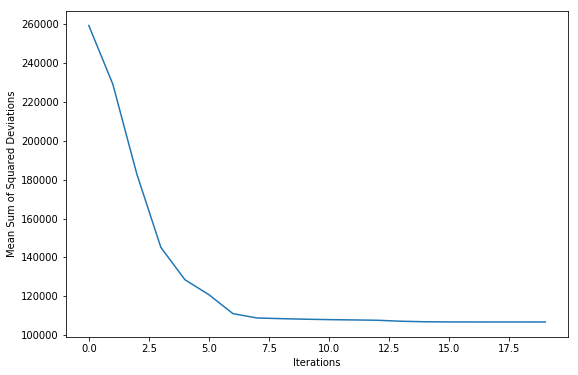

In [6]:
plt.subplots(figsize=(9,6))
plt.plot(cluster_vars)
plt.xlabel('Iterations')
plt.ylabel('Mean Sum of Squared Deviations');
plt.savefig('mean_ssd', bpi=150)

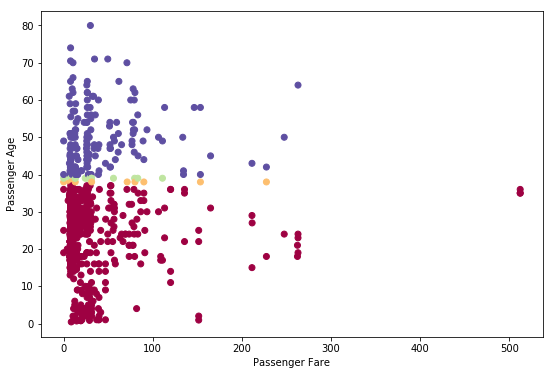

In [7]:
plt.subplots(figsize=(9,6))
plt.scatter(x=cluster_array[:,0], y=cluster_array[:,1], 
            c=initial_clusters, cmap=plt.cm.Spectral);
plt.xlabel('Passenger Fare')
plt.ylabel('Passenger Age');
plt.savefig('initial_clusters', bpi=150)

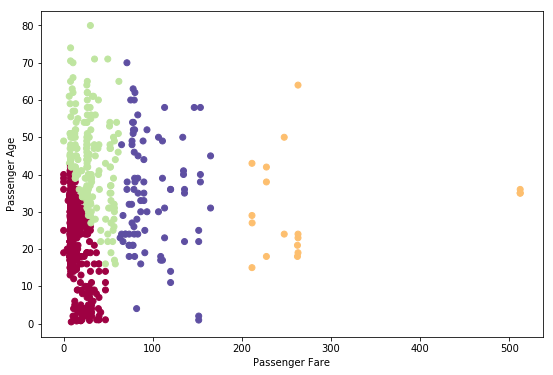

In [8]:
plt.subplots(figsize=(9,6))
plt.scatter(x=cluster_array[:,0], y=cluster_array[:,1], 
            c=clusters, cmap=plt.cm.Spectral);
plt.xlabel('Passenger Fare')
plt.ylabel('Passenger Age');
plt.savefig('final_clusters', bpi=150)

In [9]:
results_df = cluster_data.join(titanic[['Survived']], 
                               how='left').reset_index(drop=True)
results_df = pd.concat([results_df,
                        pd.DataFrame(initial_clusters, 
                                     columns=['initial_cluster']),
                        pd.DataFrame(clusters, 
                                     columns=['converged_cluster'])],
                       axis=1)

In [10]:
pivot_initial = (results_df.pivot_table(values=['Survived'], 
                                        index=['initial_cluster'],
                                        aggfunc='mean'))
pivot_initial['label'] = ['Initial' for i in range(pivot_initial.shape[0])]

pivot_converged = results_df.pivot_table(values=['Survived'], 
                                         index=['converged_cluster'],
                                         aggfunc='mean')
pivot_converged['label'] = ['Converged' for i in range(pivot_converged.shape[0])]

pivot_df = pd.concat([pivot_initial, pivot_converged], axis=0).reset_index()
pivot_df = pivot_df.rename({'index': 'Cluster',
                            'Survived': 'Survival Percentage (%)'}, axis=1)

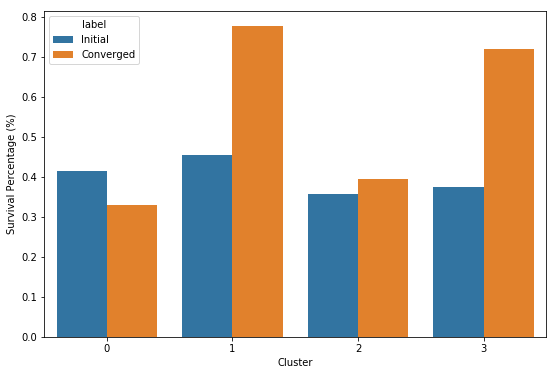

In [11]:
plt.subplots(figsize=(9,6))
sns.barplot(x='Cluster', y='Survival Percentage (%)', 
            hue='label', data=pivot_df);
plt.savefig('survival', bpi=150)